# Hit graph construction

This is a notebook for developing and analyzing the procedure for constructing hit graphs.

In [1]:
import os
import sys

# Customize sys path for user packages installed on top of Cori module pytorch-mpi/v0.4.1
sys.path.append(
    os.path.expandvars('$HOME/.local/cori/pytorchv0.4.1/lib/python3.6/site-packages')
)

# and for local code
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import trackml.dataset

## Load the data

In [3]:
# NERSC path
data_dir = '/global/cscratch1/sd/sfarrell/trackml/train_all'

# iBanks path
#data_dir = '/bigdata/shared/TrackML/train_100_events'

In [4]:
n_events = 10

# Find the input files
all_files = os.listdir(data_dir)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(data_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))
file_prefixes = file_prefixes[:n_events]

In [5]:
# Start with just one event
prefix = file_prefixes[1]
evtid = int(prefix[-9:])

hits, particles, truth = trackml.dataset.load_event(
    prefix, parts=['hits', 'particles', 'truth'])

In [6]:
hits.head(2)

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-69.271698,-0.812497,-1502.5,7,2,1
1,2,-73.308998,-8.302350,-1502.5,7,2,1


In [7]:
particles.head(2)

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.003686,0.013468,-6.5032,67.8190,-36.7019,-25.516199,-1,11
1,4503805785800704,-0.003686,0.013468,-6.5032,-3.0097,10.6623,37.389702,1,11


In [8]:
truth.head(2)

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,324262265547128832,-69.290901,-0.794919,-1502.5,-0.511341,0.019336,-11.06900,0.000009
1,2,45044036452483072,-73.306801,-8.292610,-1502.5,-0.304958,-0.054226,-6.36582,0.000009


## Hit selection

In [9]:
def select_hits(hits, truth, particles, pt_min=0):
    # Barrel volume and layer ids
    vlids = [(8,2), (8,4), (8,6), (8,8),
             (13,2), (13,4), (13,6), (13,8),
             (17,2), (17,4)]
    n_det_layers = len(vlids)
    # Select barrel layers and assign convenient layer number [0-9]
    vlid_groups = hits.groupby(['volume_id', 'layer_id'])
    hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i)
                      for i in range(n_det_layers)])
    # Calculate particle transverse momentum
    pt = np.sqrt(particles.px**2 + particles.py**2)
    particles = particles.assign(pt=pt)
    # True particle selection.
    # Applies pt cut, removes all noise hits.
    particles = particles[particles.pt > pt_min]
    truth = (truth[['hit_id', 'particle_id']]
             .merge(particles[['particle_id', 'pt']], on='particle_id'))
    # Calculate derived hits variables
    r = np.sqrt(hits.x**2 + hits.y**2)
    phi = np.arctan2(hits.y, hits.x)
    # Select the data columns we need
    hits = (hits[['hit_id', 'z', 'layer']]
            .assign(r=r, phi=phi)
            .merge(truth[['hit_id', 'particle_id', 'pt']], on='hit_id'))
    # Remove duplicate hits
    hits = hits.loc[
        hits.groupby(['particle_id', 'layer'], as_index=False).r.idxmin()
    ]
    return hits

def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

In [10]:
pt_min = 0. # GeV

In [11]:
hits = (select_hits(hits, truth, particles, pt_min=pt_min)
        .assign(evtid=evtid)
        .reset_index(drop=True))

## Geometry ID pairs

We use geometry IDs to select initial set of hit pair segments.
For now we're starting with barrel hits only and can use the 0-9 layer number as the ID.
We'll then use consecutive layer numbers as the criteria.

This logic should be made extensible to non-barrel geometry and even module-level pairings.

In [12]:
gid_keys = 'layer'
n_det_layers = 10
gid_start = np.arange(0, n_det_layers-1)
gid_end = np.arange(1, n_det_layers)

## Segment construction

Now for every geometry ID pair we construct hit-pair segments.

In [13]:
def get_segments(hits, gid_keys, gid_start, gid_end):

    # Group hits by geometry ID
    hit_gid_groups = hits.groupby(gid_keys)

    segments = []

    # Loop over geometry ID pairs
    for gid1, gid2 in zip(gid_start, gid_end):
        hits1 = hit_gid_groups.get_group(gid1)
        hits2 = hit_gid_groups.get_group(gid2)

        # Join all hit pairs together
        hit_pairs = pd.merge(
            hits1.reset_index(), hits2.reset_index(),
            how='inner', on='evtid', suffixes=('_1', '_2'))

        # Calculate coordinate differences
        dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
        dz = hit_pairs.z_2 - hit_pairs.z_1
        dr = hit_pairs.r_2 - hit_pairs.r_1
        phi_slope = dphi / dr
        z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr

        # Identify the true pairs
        y = (hit_pairs.particle_id_1 == hit_pairs.particle_id_2) & (hit_pairs.particle_id_1 != 0)

        # Put the results in a new dataframe
        segments.append(hit_pairs[['evtid', 'index_1', 'index_2', 'layer_1', 'layer_2']]
                        .assign(dphi=dphi, dz=dz, dr=dr, y=y, phi_slope=phi_slope, z0=z0))

    return pd.concat(segments, ignore_index=True)

In [14]:
segments = get_segments(hits=hits, gid_keys=gid_keys, gid_start=gid_start, gid_end=gid_end)

## Plot the full segment distributions

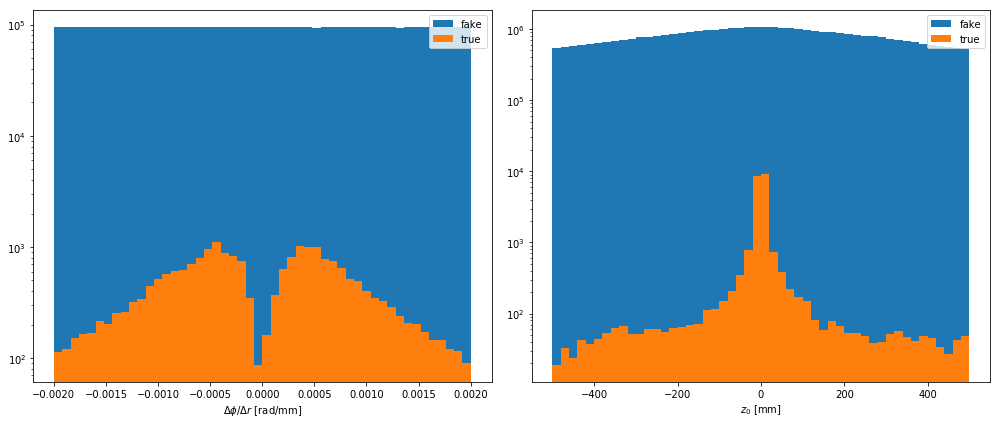

In [15]:
plt.figure(figsize=(14,6))

true_segs = segments[segments.y]
fake_segs = segments[segments.y == False]

plt.subplot(121)
binning=dict(bins=50, range=(-0.002, 0.002))
plt.hist(fake_segs.phi_slope, label='fake', log=True, **binning)
plt.hist(true_segs.phi_slope, label='true', **binning)
plt.xlabel('$\Delta \phi / \Delta r$ [rad/mm]')
plt.legend(loc=0)

plt.subplot(122)
binning=dict(bins=50, range=(-500, 500))
plt.hist(fake_segs.z0, label='fake', log=True, **binning)
plt.hist(true_segs.z0, label='true', **binning)
plt.xlabel('$z_0$ [mm]')
plt.legend(loc=0)

plt.tight_layout()

## Segment selection

In [16]:
def select_segments(segments, phi_slope_min, phi_slope_max, z0_max):
    sel_mask = ((segments.phi_slope.abs() > phi_slope_min) &
                (segments.phi_slope.abs() < phi_slope_max) &
                (segments.z0.abs() < z0_max))
    return segments.assign(selected=sel_mask)

def segment_efficiency(segments):
    return (segments.y & segments.selected).sum() / segments.y.sum()

def segment_purity(segment):
    return (segments.y & segments.selected).sum() / segments.selected.sum()

In [41]:
# Choose some cuts
phi_slope_min = 0.
phi_slope_max = 0.0006
z0_max = 100

In [42]:
segments = select_segments(segments, phi_slope_min=phi_slope_min,
                           phi_slope_max=phi_slope_max, z0_max=z0_max)

print('Selection efficiency %.4f purity %.4f' % (segment_efficiency(segments), segment_purity(segments)))

Selection efficiency 0.4279 purity 0.0874


In [43]:
# What is the selection efficiency for high pt particle segments?
true_segments = segments[segments.y]
true_seg_pt = hits.loc[true_segments.index_1].pt.values
true_segments = true_segments.assign(pt=true_seg_pt)

print('Selection efficiency for high pt particles:')
print('  %.4f for pt > 500 MeV' % segment_efficiency(true_segments[true_segments.pt > 0.5]))
print('  %.4f for pt > 1.0 GeV' % segment_efficiency(true_segments[true_segments.pt > 1]))

Selection efficiency for high pt particles:
  0.9442 for pt > 500 MeV
  0.9938 for pt > 1.0 GeV


## Sample reweighting

To deal with class imbalance, we'll want to reweight the segments in the training loss functions so that real and fake segments have nearly equal proportion.